### Setup and Target Variable Definition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df_users = pd.read_csv('users.csv', parse_dates=['signup_date'])
df_events = pd.read_csv('events.csv', parse_dates=['event_timestamp'])

# 1. Define 'Day 30' for each user
df_users['day_30_limit'] = df_users['signup_date'] + pd.Timedelta(days=30)

# 2. Check if user had ANY activity AFTER Day 30
# We'll merge events with users to see who was active post-30 days
active_post_30 = df_events.merge(df_users[['user_id', 'day_30_limit']], on='user_id')
retained_users = active_post_30[active_post_30['event_timestamp'] >= active_post_30['day_30_limit']]['user_id'].unique()

# 3. Create the target label: 1 if retained, 0 if not
df_users['is_retained_d30'] = df_users['user_id'].isin(retained_users).astype(int)

print(f"Overall Day 30 Retention: {df_users['is_retained_d30'].mean():.2%}")

Overall Day 30 Retention: 30.65%


### Feature Engineering (The First 7 Days)

In [4]:
# Define the onboarding window (First 7 days)
df_users['onboarding_limit'] = df_users['signup_date'] + pd.Timedelta(days=7)

# Merge events with the onboarding limit
df_onboarding_events = df_events.merge(df_users[['user_id', 'onboarding_limit']], on='user_id')

# Filter for events that happened ONLY in the first 7 days
df_7d = df_onboarding_events[df_onboarding_events['event_timestamp'] <= df_onboarding_events['onboarding_limit']]

# Pivot to get counts of each event type per user
behavior_7d = df_7d.groupby(['user_id', 'event_name']).size().unstack(fill_value=0).reset_index()

# Merge back to our main user dataframe
df_analysis = df_users[['user_id', 'is_retained_d30']].merge(behavior_7d, on='user_id', how='left').fillna(0)

df_analysis.head()

,user_id,is_retained_d30,log_meal,log_workout,session_start,update_profile
0,U1000,1,1.0,0.0,1.0,0.0
1,U1001,0,0.0,2.0,5.0,1.0
2,U1002,0,0.0,3.0,2.0,0.0
3,U1003,0,0.0,4.0,3.0,3.0
4,U1004,1,5.0,0.0,1.0,1.0


### Correlation & Discovery

In [7]:
# Calculate correlation between behaviors and retention
# We use numeric_only=True to skip the string-based 'user_id' column
correlations = df_analysis.corr(numeric_only=True)['is_retained_d30'].sort_values(ascending=False)

print("Correlation with Day 30 Retention:")
print(correlations.drop('is_retained_d30')) # Drop the self-correlation of the target variable

Correlation with Day 30 Retention:
log_meal          0.421684
session_start    -0.373454
update_profile   -0.389782
log_workout      -0.394358
Name: is_retained_d30, dtype: float64


### Testing the "Log Meal" Hypothesis

In [8]:
# Identify the behavior with the highest correlation (excluding the target itself)
top_behavior = correlations.drop('is_retained_d30').idxmax()
print(f"Top Correlation found: {top_behavior}")

# Compare retention rates for different thresholds of the top behavior
results = []
for i in range(0, 8):
    # Calculate retention for users who did the action AT LEAST 'i' times
    group = df_analysis[df_analysis[top_behavior] >= i]
    
    if len(group) > 0:
        retention = group['is_retained_d30'].mean()
        results.append({
            'actions_performed': i, 
            'retention_rate': retention, 
            'user_count': len(group)
        })

df_aha = pd.DataFrame(results)
# Calculate the 'Uplift' (how much better this group is than the one before it)
df_aha['uplift'] = df_aha['retention_rate'].diff()

print(df_aha)

Top Correlation found: log_meal
   actions_performed  retention_rate  user_count    uplift
0                  0        0.306500        2000       NaN
1                  1        0.353421        1593  0.046921
2                  2        0.477297         947  0.123876
3                  3        0.576336         524  0.099039
4                  4        0.720339         236  0.144003
5                  5        0.848214         112  0.127875
6                  6        0.955556          45  0.107341
7                  7        1.000000          21  0.044444


### Final Visualization for the "Aha Moment"

C:\Users\Eldu\AppData\Local\Temp\ipykernel_6500\1393784082.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_aha, x='actions_performed', y='retention_rate', palette='Blues_d')


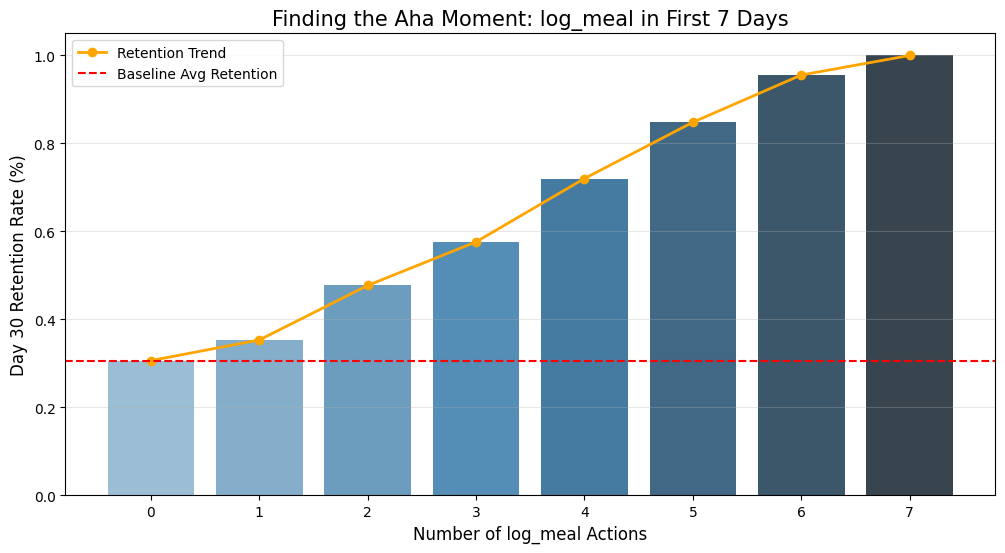

In [9]:
plt.figure(figsize=(12, 6))

# Plot the bars
sns.barplot(data=df_aha, x='actions_performed', y='retention_rate', palette='Blues_d')

# Add a trend line
plt.plot(df_aha['actions_performed'], df_aha['retention_rate'], marker='o', color='orange', linewidth=2, label='Retention Trend')

# Highlight the "Aha Moment" (usually where the rate levels off or jumps)
plt.axhline(df_users['is_retained_d30'].mean(), color='red', linestyle='--', label='Baseline Avg Retention')

plt.title(f'Finding the Aha Moment: {top_behavior} in First 7 Days', fontsize=15)
plt.xlabel(f'Number of {top_behavior} Actions', fontsize=12)
plt.ylabel('Day 30 Retention Rate (%)', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()